## Data science - Project 1 : multivariate models

---
### Summary
---

* $\textbf{Part 0 : Objective}$
* $\textbf{Part 1 : Dataset}$
* $\textbf{Part 2 : Models and enhancements}$
    - Model 1 : The linear regression from the StatsModels library
    - Model 2 : The linear regression from the Scikit Learn library
    - Model 3 : Feature scaling and Scikit Learn
    - Model 4 : Remove the outliers
    - Model 5 : Enhanced model 1 with a new cut-off
    - Model 6 : Model kNN
* $\textbf{Part 3 : Estimation}$
* $\textbf{Part 4 : Conclusions}$
---

#### || Part 0 : Objective  ||
---

First of all, the objective of this first project in data science is to program a  multivariate regression. Then, we will see how we can improve the result obtained by a simple improvement (better choice of the cut-ff value, etc.) or by new models. 

To do so we will work on a dataset composed of the price (in €) and the surface area (in m²) of an apartment in a given district. Thus, the price of each apartment of the dataset depends, for the simple case discussed here, on only two variables : the surface area and its district.

Before starting, let's import all the libraries we will need here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from colorama import init
from termcolor import colored
from mpl_toolkits.mplot3d import Axes3D
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.api import add_constant
from colorama import Fore, Back, Style
from warnings import simplefilter # import warnings filter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

---

#### || Part 1 : Dataset ||
---

First of all, let's download our dataset

In [2]:
#Download of the dataset
house_data = pd.read_csv('house_data.csv')

and see if the data are correctly downloaded

In [3]:
house_data.head(5)

,price,surface,arrondissement
0,1820,46.1,1.0
1,1750,41.0,1.0
2,1900,55.0,1.0
3,1950,46.0,1.0
4,1950,49.0,1.0


Which give us the following plot

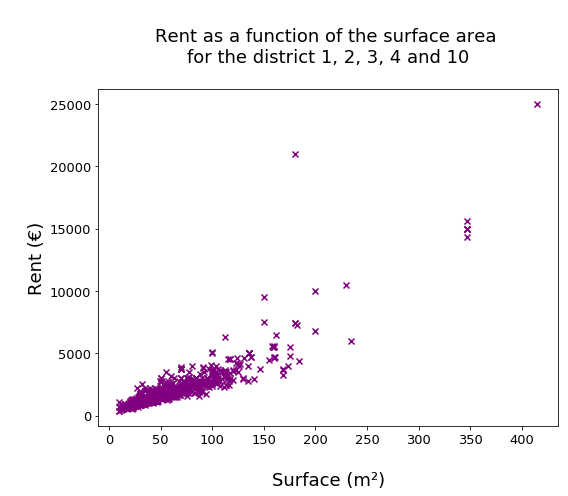

In [4]:
fig = plt.figure(figsize=(8,7))
plt.scatter(house_data["surface"], house_data["price"], c='purple', marker='x') 
plt.ylabel('\nRent (€)',fontsize = 18)
plt.xlabel('\nSurface (m²)',fontsize = 18)
plt.title("\nRent as a function of the surface area \nfor the district 1, 2, 3, 4 and 10\n",fontsize=18)
plt.tick_params(axis='both', labelsize=13)
plt.tight_layout()
plt.show()

The download seems good. Let's check the data more carefully. For this purpose, we remove the outliers

In [5]:
#Data cutting to "artificially" remove the aberrant ones (outliers)
houseData = house_data[house_data['price']<10000]

Then we check if the dataset have datas which are infinite, missing, etc.

In [6]:
print("Summary of the analysis:")
np.sum(houseData.isna())

Summary of the analysis:


price             0
surface           5
arrondissement    5
dtype: int64

This quick analyse reveal us that 5 surface values and 5 district values are NaN (Not A Number). For the rest of our work we will remove them to prevent them from affecting our conclusions.

In [7]:
#Remove all the rows with NaN values
houseData = houseData[np.isfinite(houseData['surface'])]

We can now start processing the dataset. For this purpose, we start by splitting the dataset in a training  and in a testing set.

In [8]:
#Separation of training/test set with the X variable which stand for the exemple images and y for the target annotations
xtrain, xtest = train_test_split(houseData, train_size=0.8, random_state=42)  #0.8 = usual distribution 80/20 (training/testing) 

#Retrieve the whole set of values of the target variable
Y1 = xtrain["price"]    #Training set (target)
Y2 = xtest["price"]     #Testing set (features)

#Retrieve the predictive variables (we have 2 of them here)
X1 = xtrain.drop(["price"], axis = 1)    #Training set (target)
X2 = xtest.drop(["price"], axis = 1)     #Testing set (features)

We are finally ready to train a model.

---

#### || Part 2 : Models and enhancements || 
---

##### Model 1 : The linear regression from the StatsModels library
---
$\mbox{ }$

We use the Ordinary Least Squares (OLS) method from the $\bf{StatsModels}$ library with one $\bf{explanatory\ variable}$ (surface) and one $\bf{categorial\ variable}$ (district) to obtain a $\bf{target}$, the rent of apartment.

In [9]:
X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)

estim = sm.OLS(Y1, X1).fit()
print("\nThe R² of the OLS is : {}\n".format(round(estim.rsquared,3)))     

#Extraction of the parameters
C0, C1, C2 = estim.params


The R² of the OLS is : 0.832



From the $\bf{coefficient\ of\ determination}$ ($R²$), we see that our OLS regression is not so bad but we will see later if we can enhance this result by another method.

Before that and from here, we use the testing set. Because we randomly sampled the testing set, we will sort it to work on.

In [10]:
ind = sorted(X2["surface"].index.tolist())

#Declaration of our arrays useful to store our data
sort_surf, sort_arron, sort_price = ([] for i in range(3))

for index in ind:
    sort_surf.append(X2["surface"][index])
    sort_arron.append(X2["arrondissement"][index])
    sort_price.append(Y2[index])

We want to predict the price on the basis of the parameters that we found above and the equation : 

$$y = c_0 + c_1 x_1 + c_2 x_2$$

where 
$$
    \begin{array}{ll}
        c_i \mbox{ are the parameters (i = 1, 2, ...)}\\
        x_i \mbox{ are the variables/features (i = 1, 2, ...)}\\
        y \mbox{ is the predictive function/the target}
    \end{array}
$$

which is the equation for multivariate linear regression.
Let's define two function for that.

In [11]:
def predict_price(C1, surface, C2, arrondissement, C0):
    """
    Function that compute the price by the mean of the receive coefficients 
    (of surface and district) and the surface and district datas

    inputs
    - C0, C1, C2 : float corresponding to the first, second and third 
                   coefficient obtained by the OLS
    - surface : float corresponding to a surface (in m²)
    - arrondissement : float corresponding to a district

    output
    - float corresponding to the price computed according to the equation
      y = c0 + c1 * x1 + c2 * x2 
    """
    
    return C0 + C1 * surface + C2 * arrondissement

In [12]:
def predict_all(C1, lst_surf, C2, lst_arron, C0):
    """
    Function that compute the price by the mean of the receive coefficients 
    (of surface and district) and the surface and district datas

    inputs
    - C0, C1, C2 : float corresponding to the first, second and third 
                   coefficient obtained by the OLS
    - lst_surf : array that contain the datas of surface (in m²)
    - lst_arron : array that contain the datas of district

    output
    - computed prices 
    """

    predicted_prices = []
    for index in ind:
        predicted_prices.append(predict_price(C1, lst_surf[index], C2, lst_arron[index], C0))
    
    return predicted_prices

We define some arrays for each district.

In [13]:
arr = [[[] for j in range(4)] for i in range(5)]

and make a price projection for each district thanks to the multivariate linear regression.

In [14]:
#Prediction by linear regression
price_projection = predict_all(C1, X2["surface"], C2, X2["arrondissement"], C0)

#After the prediction, we split all of this into smaller dataset according to each district
for i in range(0,len(ind)):
    if (sort_arron[i] == 1 or sort_arron[i] == 2 or 
        sort_arron[i] == 3 or sort_arron[i] == 4):
        
        indx = int(sort_arron[i] - 1)        #Case of district 1, 2, 3 or 4
    else:
        indx = int(sort_arron[i] - 6)        #Case of district 10
        
    arr[indx][0].append(sort_arron[i])
    arr[indx][1].append(sort_price[i])
    arr[indx][2].append(sort_surf[i])
    arr[indx][3].append(price_projection[i])

Let's see the result of our work

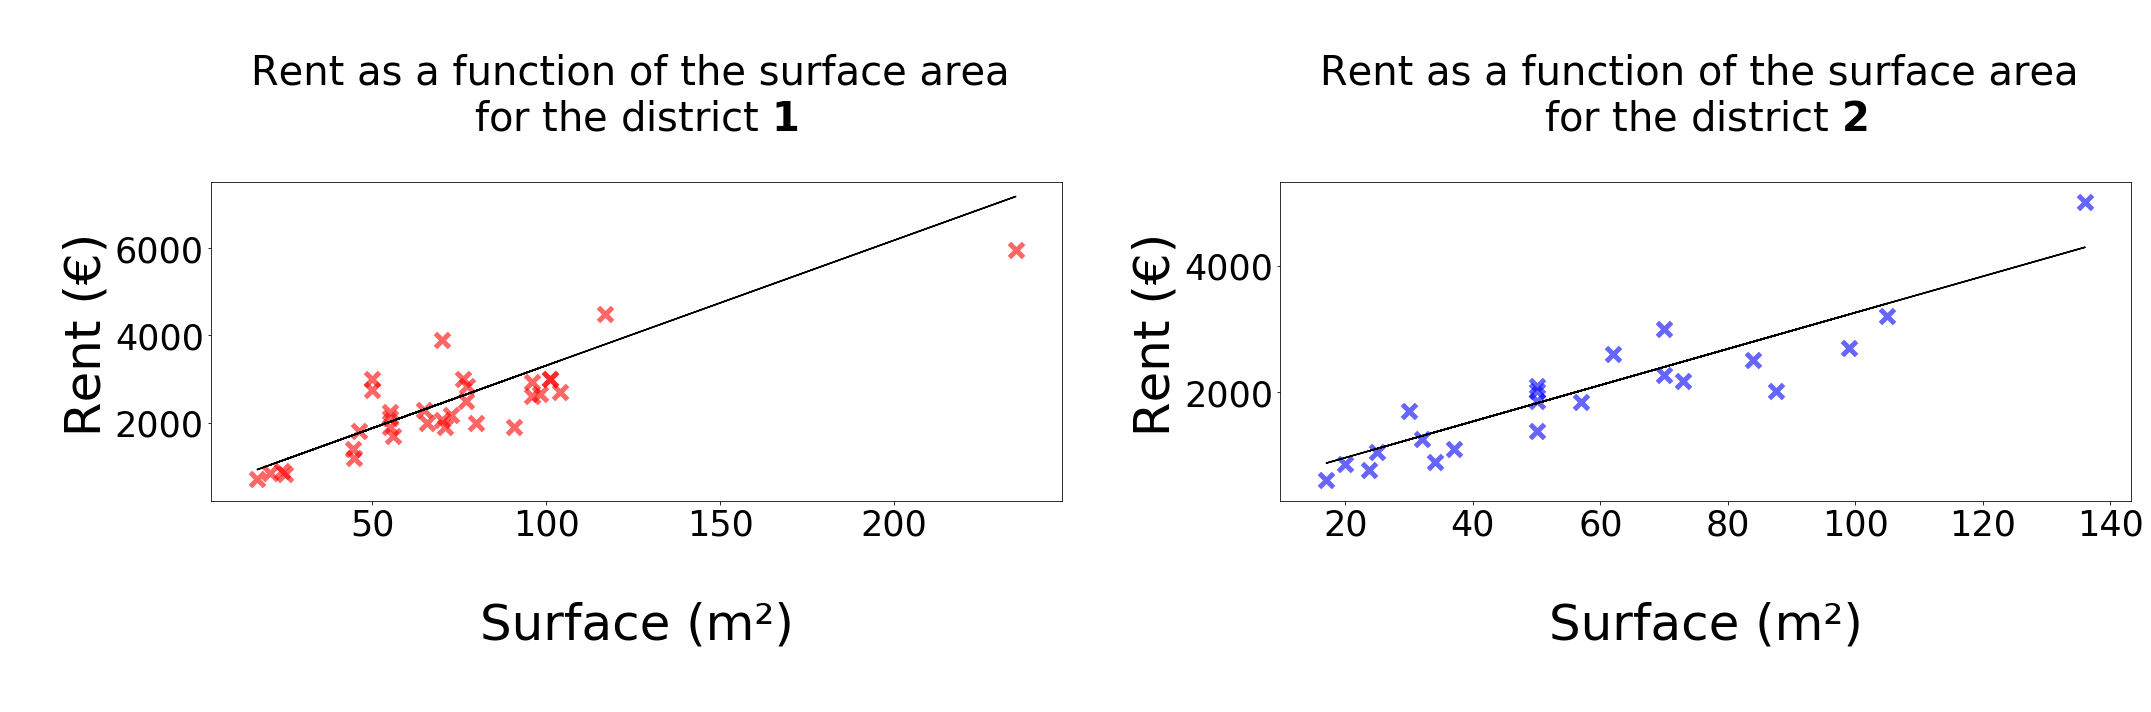

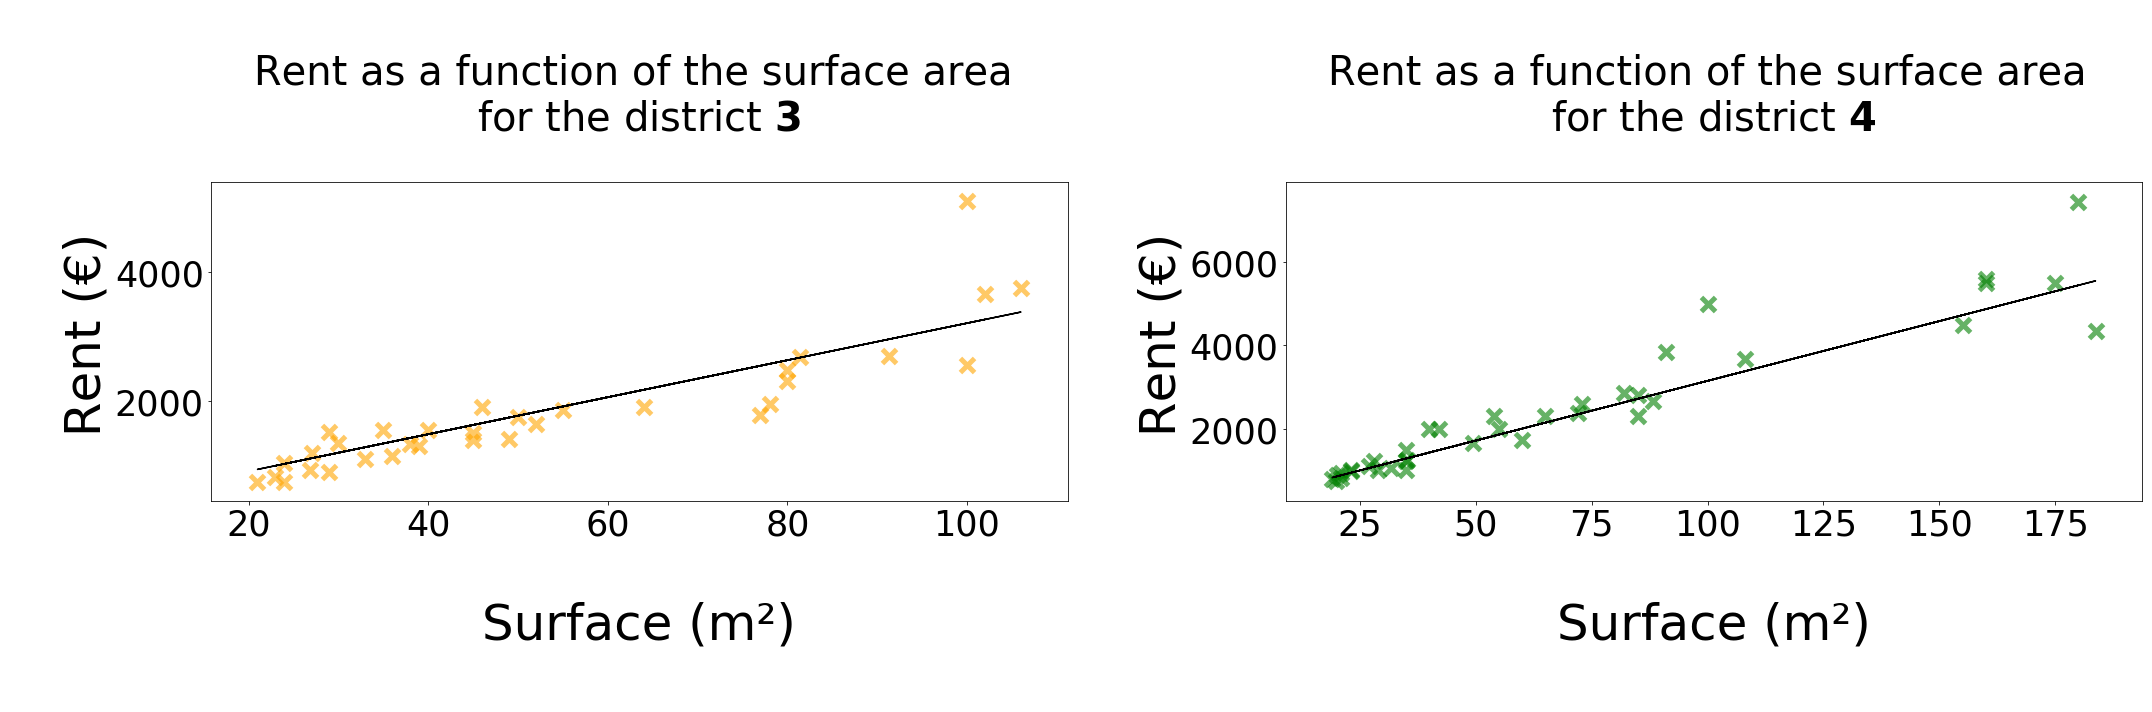

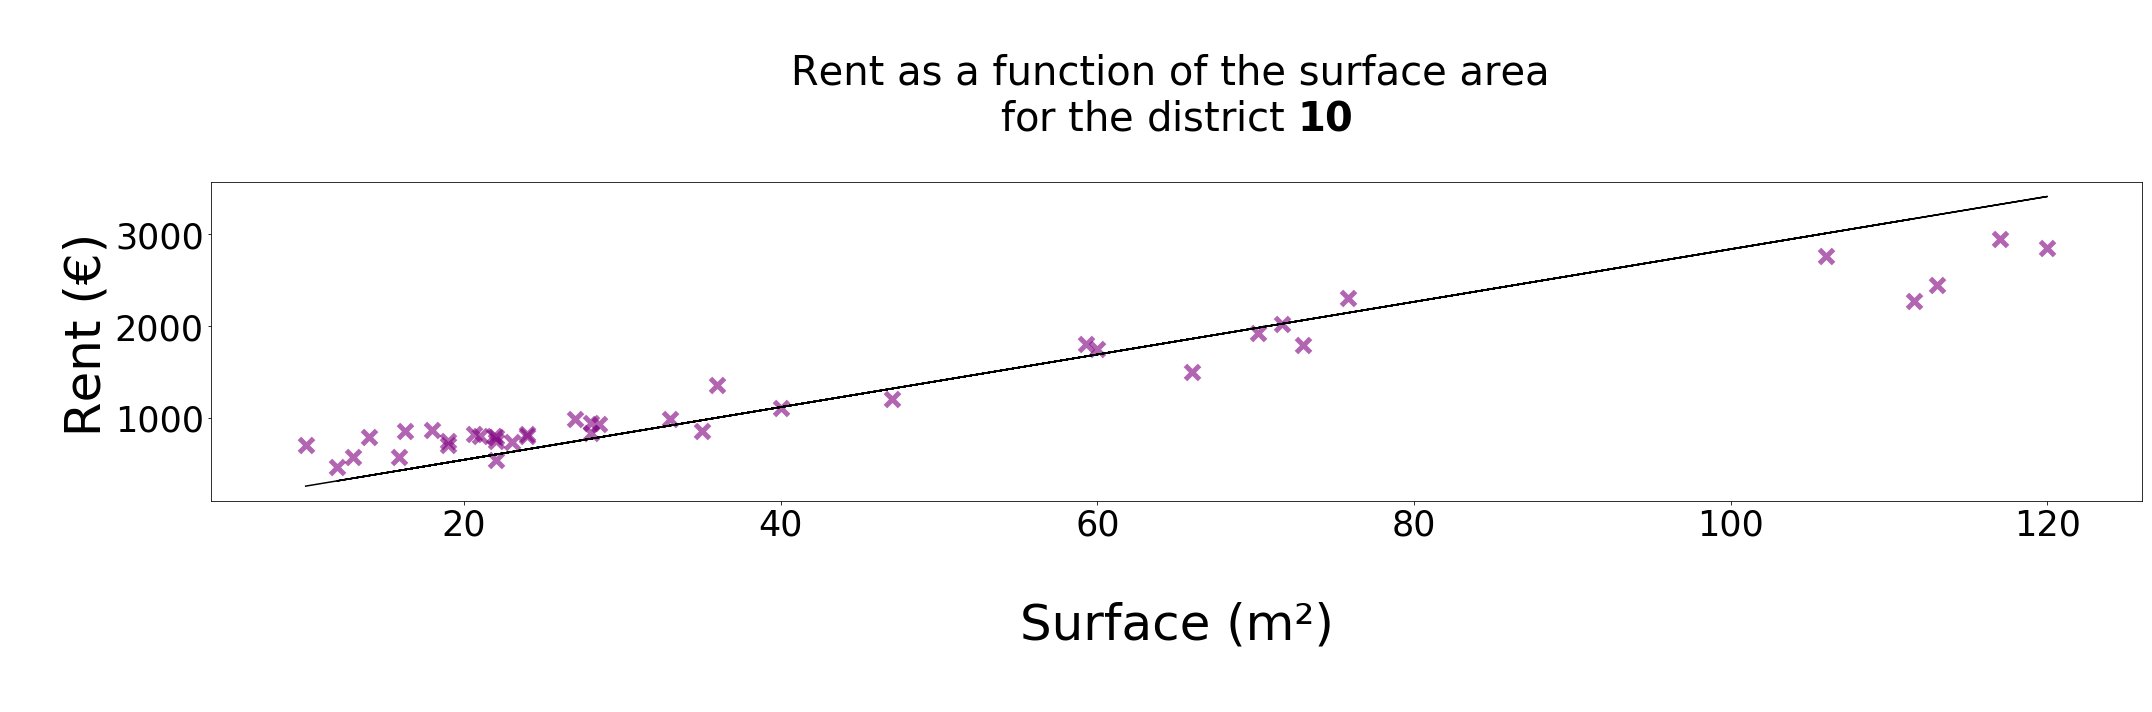

In [15]:
district = [1,2,3,4,10]
color = {1:'red', 2:'blue', 3:'orange', 4:'green', 10:'purple'}
dic = {1:1, 2:2, 3:1, 4:2, 10:1}

for dist in district :
    Ndistrict = str(dist)
    if dic[dist] == 1 :
        figure = plt.figure(figsize = (30, 10))
        figure.subplots_adjust(left = 0.1, bottom = 0.3, right = 1, top = 0.7, wspace = .5, hspace = .5)

    if (dist == 1 or dist == 2 or dist == 3 or dist == 4):
        param = 2
    else:
        param = 1
        dist = dist-5

    plt.subplot(1, param, dic[int(Ndistrict)])
    plt.title("\nRent as a function of the surface area \nfor the district " + r"$\bf{" + Ndistrict +"}$\n",fontsize=40)
    plt.plot(arr[dist-1][2], arr[dist-1][3], color ='black')
    plt.scatter(arr[dist-1][2], arr[dist-1][1], color = color[int(Ndistrict)], alpha = 0.6, s = 200, marker = 'x', linewidth=5)
    plt.xlabel('\nSurface (m²)\n',fontsize=50)
    plt.ylabel('\n Rent (€)',fontsize=50)
    plt.tick_params(axis='both', labelsize=35)
    
    if dic[int(Ndistrict)] == param:
        plt.tight_layout()
        plt.show()

From those graphics we can see that our implementation seems to be good and consistent with our $R²$ value.

---

##### Model 2 : The linear regression from the Scikit Learn library
---

In this new section, we want to see the result obtained by the linear regression from the $\bf{Scikit\ Learn}$ library. Because the linear regression is identical in both Scikit learn and StatsModels libraries, we hope that, after implementation, the result will be very similar to the one we obtained with the $\bf{StatsModels}$ library.

In [16]:
linReg = LinearRegression(fit_intercept=False,normalize=False)
result = linReg.fit(X1,Y1)

And we apply this result to the testing set.

In [17]:
print("\nAccuracy of the linear regression : R² = {}".format(round(result.score(X2,Y2),3)))


Accuracy of the linear regression : R² = 0.848


Which is, as expected, very close to the value obtained in the case of model 1 ($R² =$ 0.832).

---

##### Model 3 : Feature scaling and Scikit Learn
---

From the different plots we've made so far, we can observed the scale of prices (rent) is two orders of magnitude higher than the surface areas. Therefore, it may be interesting to do a scaling of our predictive variables. For this task, we will use a class, $\bf{StandardScaler}$, of the package $\bf{sklearn.preprocessing}$ from the $\bf{Scikit learn}$ library. Let's have a look at this.

In [18]:
#Training set
scaler1 = StandardScaler().fit(X1)
X1_scaled= scaler1.transform(X1)

#Testing set
scaler2 = StandardScaler().fit(X2)
X2_scaled= scaler2.transform(X2)

linReg = LinearRegression()
result = linReg.fit(X1_scaled,Y1)
print("\nAccuracy of the linear regression : R² = {}\n".format(round(result.score(X2_scaled,Y2),3)))


Accuracy of the linear regression : R² = 0.837



From here we see that the scaling give us a less accurate result in comparison with the previous result (model 2 : $R²= 0.848$). We can conclude that, for a linear regression, scaling is not useful.

---
##### Model 4 : Remove the outliers
---

For this fourth model, we want to see if the number of outliers has an significant impact on the result that we get. To see that, we will perform a loop that will progressively change the limit (cut-off) beyond which the data are considered as outliers. For the rest of the script, nothing will change from what we did previously (model 2).

In [19]:
results=[]

for i in range (500,25000,500):
    dataset = houseData[houseData["price"] < i]
    dataset = sm.add_constant(dataset)
    #Separation of training/test set with the X variable which stand for the exemple images and y for the target annotations
    dataset_xtrain, dataset_xtest = train_test_split(dataset, train_size=0.8, random_state=42)  #0.8 = usual distribution 80/20 (training/testing) 

    dataset_Y1 = dataset_xtrain["price"]    #Training set (target)
    dataset_Y2 = dataset_xtest["price"]     #Testing set (features)
    
    dataset_X1 = dataset_xtrain.drop(["price"], axis = 1)    #Training set (target)
    dataset_X2 = dataset_xtest.drop(["price"], axis = 1)     #Testing set (features)

    linRegre = LinearRegression(fit_intercept=False,normalize=False)
    linRegre.fit(dataset_X1,dataset_Y1)
    new_result=linRegre.score(dataset_X2,dataset_Y2)
    results.append((i,new_result))
    
results = pd.DataFrame(results)
results.columns = ['Price', 'Score']
indx = float(results.index.get_indexer_for(results[results["Score"] == results["Score"].max()].index))

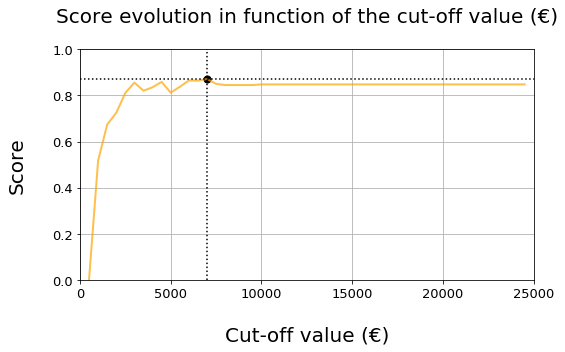


Best score : R² = 0.872

Corresponding cut-off (price limit) : 7000 €

Fraction, in our dataset, of outliers corresponding to this score : 0.02 %


In [20]:
fig = plt.figure(figsize = (8,5))
plt.plot(results["Price"],results["Score"], color = 'orange',alpha = 0.7, linewidth = 2)
#réglage du point
plt.scatter([results["Price"][indx],],[results["Score"][indx],], 50, color ='k')
plt.axhline(results["Score"][indx], color='black', linestyle = ':')
plt.axvline(results["Price"][indx], color='black', linestyle = ':')
plt.xlabel("\nCut-off value (€)", fontsize = 20)
plt.ylabel("Score\n", fontsize = 20)
plt.ylim(0,1)
plt.xlim(0,25000)
plt.grid(True)
plt.title("Score evolution in function of the cut-off value (€)\n", fontsize = 20)
plt.tick_params(axis = "both", labelsize = 13)
plt.tight_layout()
plt.show()

N_outliers = house_data[house_data["price"]>= results["Price"][indx]].count()
frac = N_outliers/house_data["price"].count()
print("\nBest score : R² = {}".format(round(results["Score"].max(),3)))
print("\nCorresponding cut-off (price limit) : {} €".format(round(results["Price"][indx],2)))
print("\nFraction, in our dataset, of outliers corresponding to this score : {} %".format(round(frac["price"],2)))

From those results, we see that :
* the score is better than the one we obtained with model 2 ($R² = 0.848$) and 1 ($R²= 0.832$)
* the corresponding fraction of outliers is not significant and therefore seems reasonable
* there is not a lot of change in the score passed the cut-off of 7000 €
* the different results observed between model 1 and model 3 can be explained by the method we used : OLS for model 1 and LR for model 2. 

To be consistent we need to use the new cut-off for model 1 and see what we get. Let's do this.

---

##### Model 5 : Enhanced model 1 with a new cut-off
---

For this fifth model, we simply use the optimal cut-off found previously.

In [21]:
#Data cutting
M4_houseData = house_data[house_data['price']<7000]
#Remove all the rows with NaN values
M4_houseData = M4_houseData[np.isfinite(M4_houseData['surface'])]
M4_xtrain, M4_xtest = train_test_split(M4_houseData, train_size=0.8, random_state=42)  #0.8 = usual distribution 80/20 (training/testing) 

M4_Y1 = M4_xtrain["price"]    #Training set (target)
M4_Y2 = M4_xtest["price"]     #Testing set (features)

M4_X1 = M4_xtrain.drop(["price"], axis = 1)    #Training set (target)
M4_X1 = sm.add_constant(M4_X1)
M4_X2 = M4_xtest.drop(["price"], axis = 1)     #Testing set (features)
M4_X2 = sm.add_constant(M4_X2)

In [22]:
M4_estim = sm.OLS(M4_Y1, M4_X1).fit()
print("\nR² obtained by OLS with the new cut-off : {}".format(round(M4_estim.rsquared,3)))


R² obtained by OLS with the new cut-off : 0.85


Like we though : 
* the result obtained by model 1 ($R² = 0.832$) with the new cut-off is a little better ($R² = 0.850$) and is consistent which what we observed when we applied this new cut off on model 2
* nevertheless, this result does not change much, which is consistent with what we observed in the plot above, i.e, little change in the score after a cut-off of 7000 €

##### Model 6 : Model kNN

Finally, we want apply a new algorithm on our dataset : the $\bf{K\ nearest\ neighborns}$ (kNN) from the $\bf{Scikit\ Learn}$ library.

$\underline{\text{Note :}}$ to test the kNN model, we use the dataset with the optimal cut-off value.

In [23]:
#Number of neighbors
k = np.linspace(1,50,50)
k = [int(i) for i in k]
params = {'n_neighbors':k}

#kNN regressor
knn = KNeighborsRegressor()

#Search for the optimal nearest neighbor number
model = GridSearchCV(knn, params, cv=5)
model.fit(M4_X1, M4_Y1)

print("\nBest score obtained with the kNN : R² = {}\n\nCorresponding (optimal) number of neighbors : {}\n".format(round(model.score(M4_X2, M4_Y2),3),model.best_params_))


Best score obtained with the kNN : R² = 0.902

Corresponding (optimal) number of neighbors : {'n_neighbors': 3}



This can be visualized on the following plot

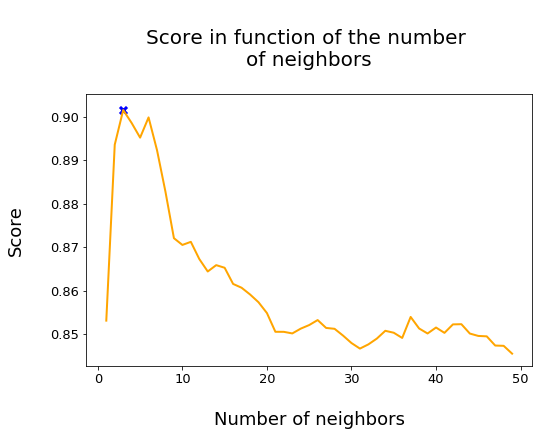


The best score (R² = 0.902) is obtained for a kNN with 3 neighbors.


In [24]:
knn_res, k_neighbors  = ([] for i in range(2))       #District 1

for i in range(1,50):
    k_neighbors.append(i)
    knn = KNeighborsRegressor(n_neighbors=i)   #Estimator initialisation
    knn.fit(M4_X1, M4_Y1)                      #Training
    knn_res.append(knn.score(M4_X2, M4_Y2))    #Testing
    
fig = plt.figure(figsize = (8,5))
plt.plot(k_neighbors,knn_res, color = 'orange', linewidth = 2)
plt.scatter(k_neighbors[knn_res.index(np.max(knn_res))],np.max(knn_res), color = 'blue', marker ="x", s=50, linewidth = 3)
plt.xlabel("\nNumber of neighbors",fontsize = 18)
plt.ylabel("Score\n",fontsize = 18)
plt.title("\nScore in function of the number \nof neighbors\n", fontsize = 20)
plt.tick_params(axis = "both", labelsize = 13)
plt.show()

print("\nThe best score (R² = {}) is obtained for a kNN with {} neighbors.".format(round(np.max(knn_res),3),k_neighbors[knn_res.index(np.max(knn_res))]))

In conclusion, we see that the kNN model is the best model ($R² = 0.902$) tried .

---

#### || Part 3 : Estimation ||
---

Now, I let you play with the $\color{red}{\text{Rent estimator}}$ which allow you to obtain the price of an apartment for a given (by yourself) surface (in m²) and district.


### Rent estimator ###

In order to estimate the price of the apartment you are looking for, please first of all, indicate the desired surface area (in m²) :
88

Please, enter the district (1, 2, 3, 4 or 10) in which you are looking for an apartment :
2


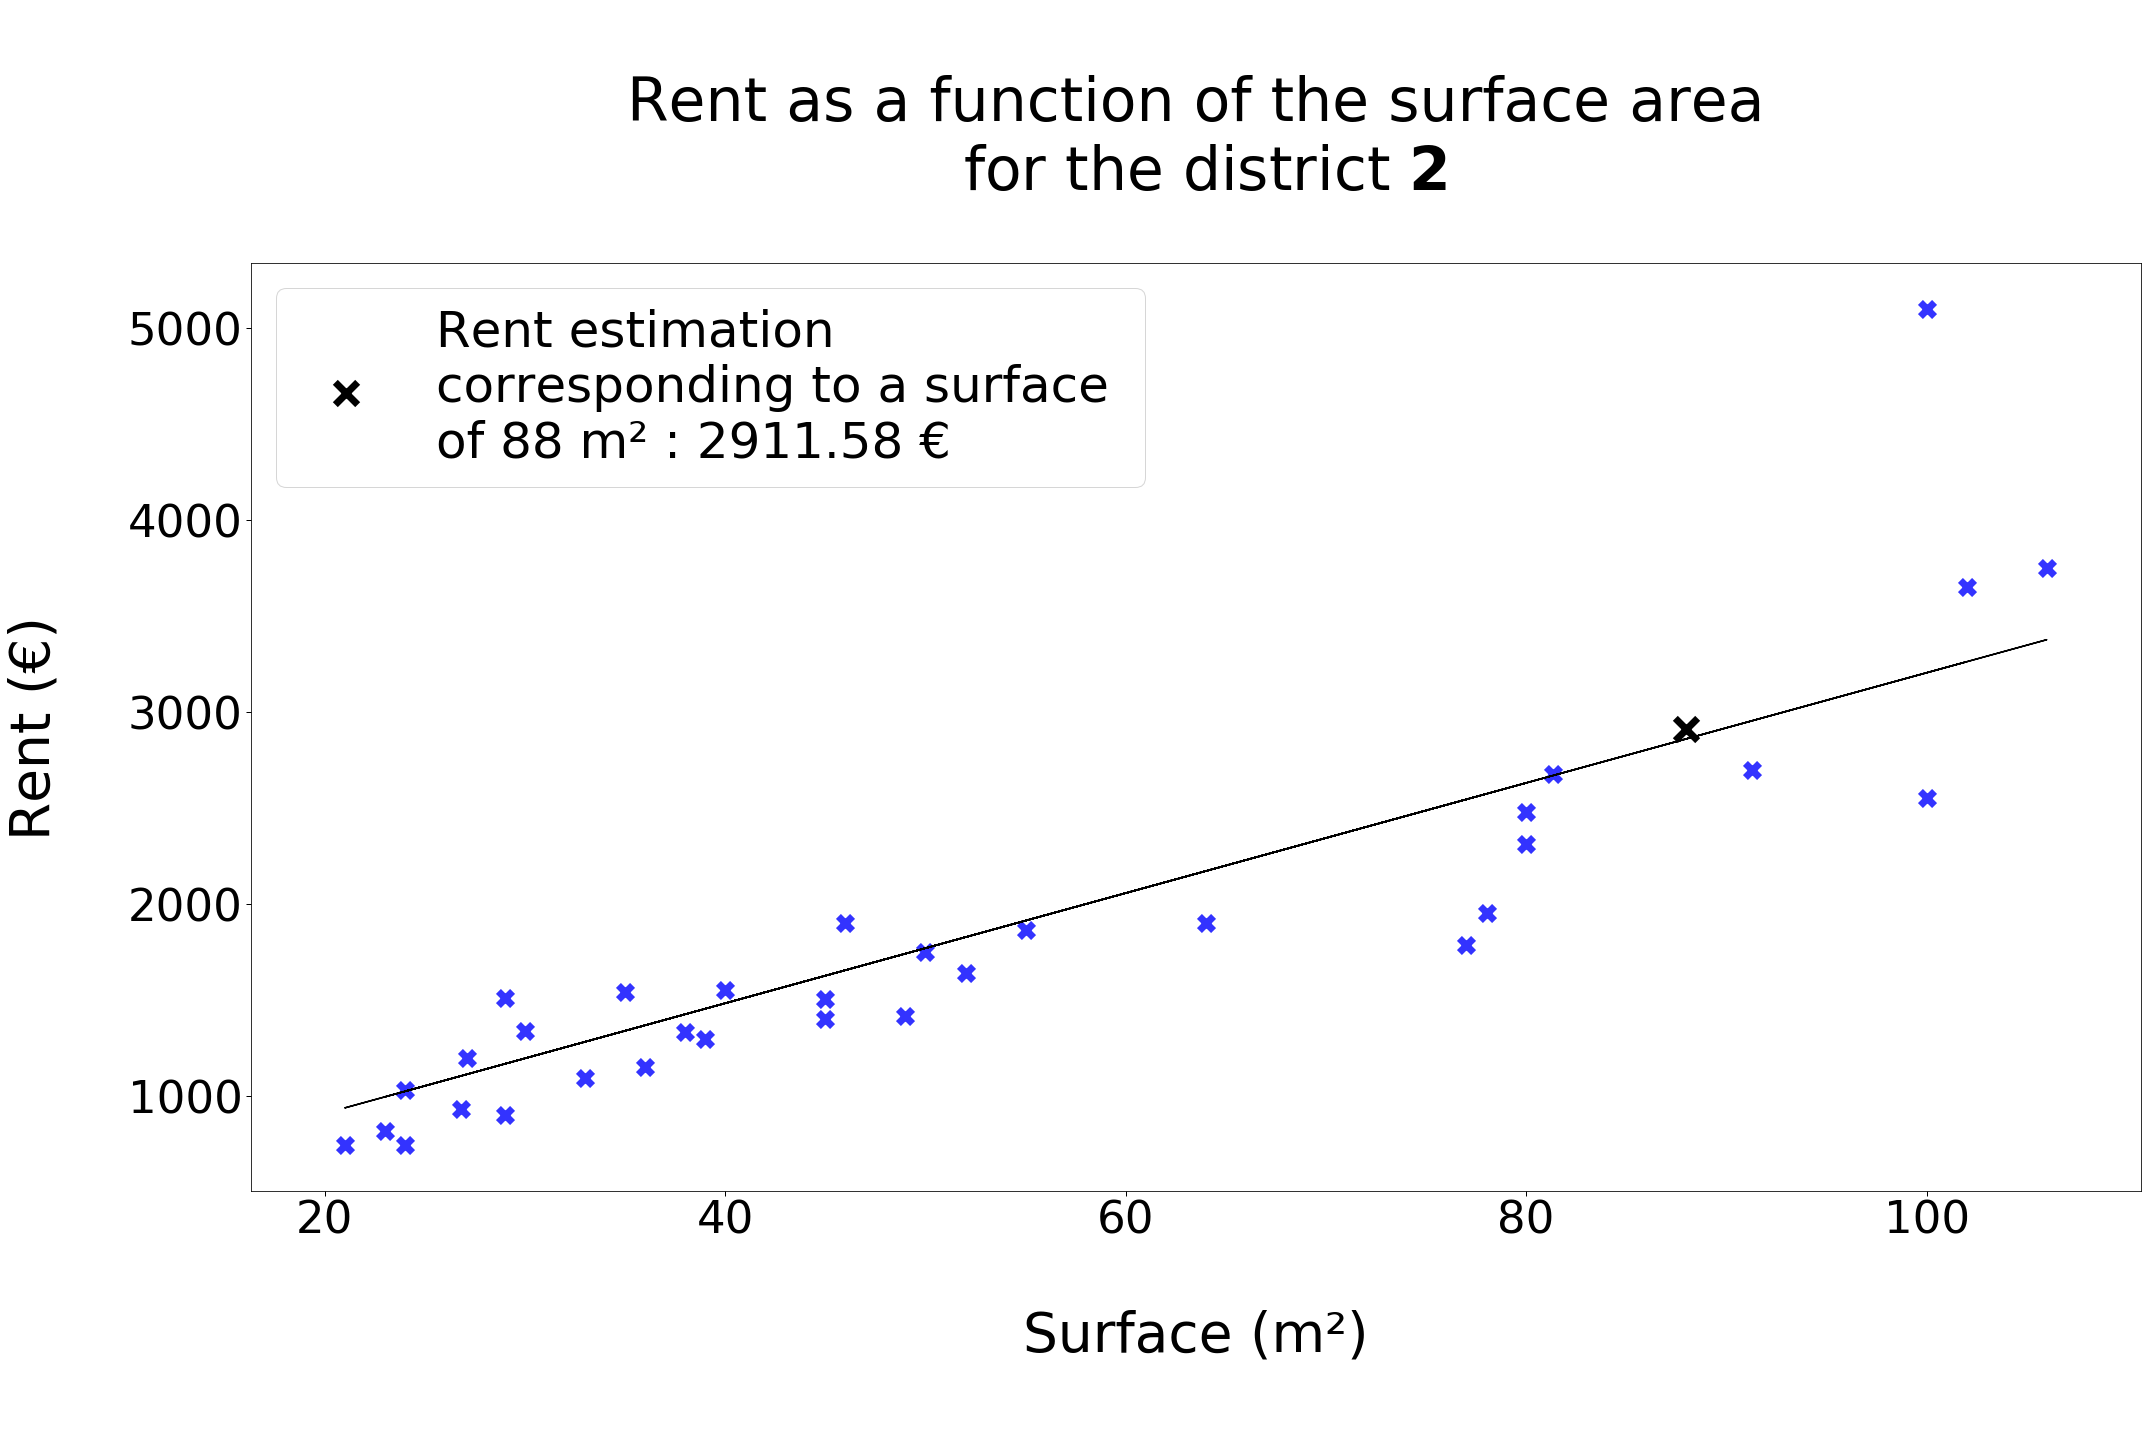

In [25]:
print(colored("\n### Rent estimator ###",'red'))
answ_arr = False
answ_surf = int(input("\nIn order to estimate the price of the apartment you are looking for, please first of all, indicate the desired surface area (in m²) :\n"))

while (answ_arr == False):
    answ_arron = int(input("\nPlease, enter the district (1, 2, 3, 4 or 10) in which you are looking for an apartment :\n"))
    if (answ_arron == 1 or answ_arron == 2 or answ_arron == 3 or answ_arron == 4 or answ_arron == 10):
        answ_arr = True
    else :
        print(colored('\n!!! Invalid entry !!! Please try again. District can only be one of the following : 1, 2, 3, 4 or 10','red'))

price_estim = predict_price(C1, answ_surf, C2, answ_arron, C0)
    
#Corresponding plot
figure = plt.figure(figsize = (30, 20))
plt.xlabel('\nSurface (m²)\n',fontsize=55)
plt.ylabel('Rent (€)\n',fontsize=55)
plt.title("\nRent as a function of the surface area\n for the district " + r"$\bf{" + str(answ_arron) +"}$\n",fontsize=60)
plt.tick_params(axis='both', which = 'minor', width = 1, length = 3, color = 'black', labelsize=45)
plt.tick_params(axis='both', which = 'major', width = 1, length = 5, color = 'black', labelsize=45)
plt.plot(arr[answ_arron][2], arr[answ_arron][3], color ='black')
plt.scatter(arr[answ_arron][2], arr[answ_arron][1], color = color[answ_arron], alpha = 0.8, s = 200, marker = 'x', linewidth=7)
p2 = plt.scatter(answ_surf, price_estim, color = 'black', s = 500, marker = 'x', linewidth=7, label = "Rent estimation : {} €".format(round(price_estim,2)))
plt.legend([p2],["Rent estimation \ncorresponding to a surface \nof {} m² : {} €".format(answ_surf ,round(price_estim,2))], fontsize=50)
plt.tight_layout()
plt.show()

---

#### || Part 4 : Conclusions ||
---

We have see different model from which we have :
* Linear regression (LRSM) from the StatsModels library
* Linear regression (LRSL) from the Scikit Learn library
* K Nearest Neighborns (kNN)

The LRSM and the LRSL have been enhanced with some sucess that we can resume in the following table :

$\mbox{}$

|    Library   | Model number |                      Description                      |   R²  |
|:------------:|:------------:|:-----------------------------------------------------:|:-----:|
|  StatsModels |    Model 1   |                   Linear regression                   | 0.832 |
| Scikit Learn |    Model 2   |                   Linear regression                   | 0.848 |
| Scikit Learn |    Model 3   |         Linear regression with feature scaling        | 0.837 |
| Scikit Learn |    Model 4   | Linear regression without outliers (accurate cut-off) | 0.872 |
|  StatsModels |    Model 5   |        Linear regression with accurate cut-off        | 0.850 |
| Scikit Learn |    Model 6   |                          KNN                          | 0.902 |

$\mbox{}$

For the linear regression models, we observe that the best results are obtained with models from the Scikit Learn library. Moreover, selecting a new cut-off value will significantly enhance the score obtained.

However, this conclusion is strongly influenced by the fact that, initially, we arbitrarily chose our cut-off value well. Therefore, future dataset processing should start with the search for the best cut-off value.

Finally, among all the models we have seen in this project, the kNN model stands out clearly and gives the best results to make a prediction.

---

###### The cell below loads the style of the notebook.

In [26]:
from IPython.core.display import HTML
css_file = 'styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())